# Анализ факторов инвестиционной привлекательности стартапов

## Введение

Финансовая компания, которая предоставляет льготные займы стартапам, хочет войти на инвестиционный рынок с прицелом на покупку, развитие и последующую перепродажу перспективных стартапов. Для разработки модели бизнеса нужна информация. Чтобы выработать общее понимание, какие данные могут быть полезны, проводится исследование на исторических данных.

Данные неполны, поэтому заказчик, кроме ответа на некоторые интересующие его вопросы, просит аккуратно относиться к получаемым в процессе исследования значениям показателей и выводам и стараться оценивать их на возможные искажения.

**Цель исследования** — выявить ключевые признаки и показатели, которые повышают вероятность успешной сделки по покупке стартапа, для улучшения оценки инвестиционной привлекательности.

### Описание данных
В проекте будут использованы следующие датасеты:
- `acquisition.csv` — содержит информацию о покупках одними компаниями других компаний;
- `company_and_rounds.csv` — cодержит информацию о компаниях и раундах финансирования;
- `education.csv` — содержит информацию об образовании сотрудника;
- `people.csv` — содержит информацию о сотрудниках;
- `degrees.csv` — содержит информацию о типе образования сотрудника.

### Содержимое проекта

1. Знакомство с данными: загрузка и первичная предобработка.
2. Предобработка данных, предварительное исследование.
3. Исследовательский анализ объединённых таблиц.
4. Итоговый вывод и рекомендации.

---


## Шаг 1. Знакомство с данными: загрузка и первичная предобработка

In [1]:
#!pip install missingno

In [76]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### 1.1. Вывод общей информации, исправление названия столбцов

In [3]:
# Загружаем данные
path = 'https://code.s3.yandex.net/datasets/'
company_and_rounds_df = pd.read_csv(path + 'company_and_rounds.csv')
acquisition_df = pd.read_csv(path + 'acquisition.csv')
people_df = pd.read_csv(path + 'people.csv')
education_df = pd.read_csv(path + 'education.csv')
degrees_df = pd.read_csv(path + 'degrees.csv')
fund_df = pd.read_csv(path + 'fund.csv')
investment_df = pd.read_csv(path + 'investment.csv')

**Познакомимся с данными датасета `company_and_rounds_df`**

In [4]:
company_and_rounds_df.head()

,company ID,name,category code,status,founded at,closed at,domain,network username,country code,investment rounds,...,milestones,funding round id,company id,funded at,funding round type,raised amount,pre money valuation,participants,is first round,is last round
0,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,888.0,1.0,2005-10-01,series-a,5250000.0,0.0,2.0,0.0,1.0
1,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,889.0,1.0,2007-01-01,series-b,9500000.0,0.0,3.0,0.0,0.0
2,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,2312.0,1.0,2008-05-19,series-c+,25000000.0,0.0,4.0,1.0,0.0
3,10.0,Flektor,games_video,acquired,NaN,NaN,flektor.com,NaN,USA,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100.0,There,games_video,acquired,NaN,NaN,there.com,NaN,USA,0.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
company_and_rounds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217774 entries, 0 to 217773
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   company  ID            217472 non-null  float64
 1   name                   217472 non-null  object 
 2   category  code         143886 non-null  object 
 3   status                 217472 non-null  object 
 4   founded  at            109956 non-null  object 
 5   closed  at             3449 non-null    object 
 6   domain                 147159 non-null  object 
 7   network  username      95534 non-null   object 
 8   country  code          108607 non-null  object 
 9   investment  rounds     217472 non-null  float64
 10  funding  rounds        217472 non-null  float64
 11  funding  total         217472 non-null  float64
 12  milestones             217472 non-null  float64
 13  funding  round  id     52928 non-null   float64
 14  company  id            52928 non-nul

Датасет `company_and_rounds_df` содержит 22 столбца и 217774 строк, в которых представлена информация о компаниях и раундах финансирования.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов лучше привести к одному виду — snake case.
- Данные содержат 12 столбцов типа `float64` и 10 столбцов типа `object`.  
  - Данные в столбцах `category  code`, `funding  round  type` и `status` представлены ограниченным набором значений и хранятся в типе `object` — эти столбцы следует перевести в тип `category`.
  - Столбцы `funded  at` и `founded_at` следует перевести в тип `data`.
  - Данные в столбцах `is  first  round` и `is  last  round` следует перевести в тип `bool`, т.к. они содержат логические значения 1 и 0.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

**Теперь познакомимся с данными датасета `acquisition_df`**

In [6]:
acquisition_df.head()

,id,acquiring_company_id,acquired_company_id,term_code,price_amount,acquired_at
0,1,11,10,NaN,20000000,2007-05-30
1,7,59,72,cash,60000000,2007-07-01
2,8,24,132,cash,280000000,2007-05-01
3,9,59,155,cash,100000000,2007-06-01
4,10,212,215,cash,25000000,2007-07-01


In [7]:
acquisition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9407 entries, 0 to 9406
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    9407 non-null   int64 
 1   acquiring_company_id  9407 non-null   int64 
 2   acquired_company_id   9407 non-null   int64 
 3   term_code             1831 non-null   object
 4   price_amount          9407 non-null   int64 
 5   acquired_at           9378 non-null   object
dtypes: int64(4), object(2)
memory usage: 441.1+ KB


Датасет `acquisition_df` содержит 6 столбцов и 9407 строк, в которых представлена информация о покупках одними компаниями других компаний.

После первичного анализа данных можно сделать следующие выводы:
- Данные содержат 4 столбца типа `int64` и 2 столбца типа `object`.  
  - Столбец `term_code` следует перевести в тип `category`, т.к. данные в этом столбце представлены ограниченным набором значений.
  - Столбец `acquired_at` следует перевести в тип `data`, т.к. данные содержат значения дат.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

**Теперь познакомимся с данными датасета `people_df`**

In [8]:
people_df.head(100)

,id,first_name,last_name,company_id,network_username
0,10,Mark,Zuckerberg,5.0,NaN
1,100,Peter,Lester,27.0,NaN
2,1000,Dr. Steven,E. Saunders,292.0,NaN
3,10000,Neil,Capel,2526.0,NaN
4,100000,Sue,Pilsch,NaN,NaN
...,...,...,...,...,...
95,100124,Simone,Biagiotti,163822.0,365albe
96,100125,Michele,Orsi,NaN,micheleorsi
97,100126,DaniÃ«l,Goyvaerts,NaN,NaN
98,100127,Todd,Sullivan,NaN,NaN


In [9]:
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                226709 non-null  int64  
 1   first_name        226704 non-null  object 
 2   last_name         226708 non-null  object 
 3   company_id        34615 non-null   float64
 4   network_username  38867 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.6+ MB


Датасет `people_df` содержит 5 столбцов и 226709 строк, в которых представлена информация о сотрудниках.

После первичного анализа данных можно сделать следующие выводы:
- Данные содержат один столбец типа `int64`, один столбец типа `float64` и 3 столбца типа `object`. Типы данных соответствуют содержимому. 
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

**Теперь познакомимся с данными датасета `education_df`**

In [10]:
education_df.head()

,id,person_id,instituition,graduated_at
0,1,6117,NaN,NaN
1,2,6136,"Washington University, St. Louis",1990-01-01
2,3,6136,Boston University,1992-01-01
3,4,6005,University of Greenwich,2006-01-01
4,5,5832,Rice University,NaN


In [11]:
education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            109610 non-null  int64 
 1   person_id     109610 non-null  int64 
 2   instituition  109555 non-null  object
 3   graduated_at  58054 non-null   object
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


Датасет `education_df` содержит 4 столбца и 109610 строк, в которых представлена информация об образовании сотрудника.

После первичного анализа данных можно сделать следующие выводы:
- Данные содержат два столбца типа `int64` и 2 столбца типа `object`. Столбец `graduated_at` следует перевести в тип `data`, т.к. данные содержат значения дат.
- Название столбца с информацией о названии учебного заведения содержит опечатку: следует исправить `instituition` на `institution`.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.


In [12]:
# Исправим опечатку в названии столбца с информацией об учебном заведении
education_df.rename(columns = {'instituition': 'institution'}, inplace = True) 


---

**Теперь познакомимся с данными датасета `degrees_df`**

In [13]:
degrees_df.head()

,id,object_id,degree_type,subject
0,1,p:6117,MBA,NaN
1,2,p:6136,BA,"English, French"
2,3,p:6136,MS,Mass Communication
3,4,p:6005,MS,Internet Technology
4,5,p:5832,BCS,"Computer Science, Psychology"


In [14]:
degrees_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           109610 non-null  int64 
 1   object_id    109610 non-null  object
 2   degree_type  98392 non-null   object
 3   subject      81298 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB


Датасет `degrees_df` содержит 4 столбца и 109610 строк, в которых представлена информация о типе образования сотрудника.

После первичного анализа данных можно сделать следующие выводы:
- Данные содержат один столбец типа `int64` и 3 столбца типа `object`. Типы данных соответствуют содержимому. 
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

### 1.2. Смена типов и анализ пропусков

- Обработайте типы данных в столбцах, которые хранят значения даты и времени, если это необходимо.
- Оцените полноту данных — сделайте предварительный вывод, достаточно ли данных для решения задач проекта.

**Поработаем с датасетом `company_and_rounds_df`**

In [15]:
# Подключаем модуль re для работы с регулярными выражениями
import re

# Приведем названия столбцов в датасете company_and_rounds_df к виду snake_case
company_and_rounds_df.columns = [
    re.sub(r'\s+', '_', column.strip().lower()) for column in company_and_rounds_df.columns
]

После преобразования названий столбцов к виду snake_case в датафрейме появилось два столбца с одинаковыми названиями — переименуем один из них.

In [16]:
company_and_rounds_df.columns.values[0] = 'company_id1'

In [17]:
# Поменяем типы данных в столбцах
company_and_rounds_df[['category_code', 'status', 'funding_round_type']] = company_and_rounds_df[['category_code', 'status', 'funding_round_type']].astype('category')
company_and_rounds_df[['is_first_round', 'is_last_round']] = company_and_rounds_df[['is_first_round', 'is_last_round']].astype('bool')

In [18]:
# Поменяем типы данных для всех столбцов, подразумевающих тип даты datetime
def process_to_datetime(column):
    """
    Функция, которая выполняет действия над столбцом.
    Например, преобразует столбцы с '_at' в datetime.
    """
    if '_at' in column.name:  # Проверяем, содержит ли название столбца '_at'
        return pd.to_datetime(column)  # Преобразуем в datetime
    return column  # Возвращаем столбец без изменений

# Основная функция для обработки датасетов
def process_datasets(dataset_dict, column_processor):
    """
    Функция, которая проходит по каждому датасету в словаре и каждому столбцу,
    применяя к ним функцию column_processor.
    """
    for dataset_name, dataset in dataset_dict.items():  # Проходим по каждому датасету в словаре
        for column_name in dataset.columns:  # Проходим по каждому столбцу
            dataset[column_name] = column_processor(dataset[column_name])  # Применяем функцию
    return dataset_dict
    
# Словарь датасетов
dataset_dict = {
    'company_and_rounds_df': company_and_rounds_df,
    'acquisition_df': acquisition_df,
    'education_df': education_df,
    'fund_df': fund_df
}

# Обрабатываем датасеты
processed_datasets = process_datasets(dataset_dict, process_to_datetime)

# Выводим результат
for dataset_name, dataset in processed_datasets.items():
    display(f"Датасет '{dataset_name}':")
    display(dataset.info())

"Датасет 'company_and_rounds_df':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217774 entries, 0 to 217773
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   company_id1          217472 non-null  float64       
 1   name                 217472 non-null  object        
 2   category_code        143886 non-null  category      
 3   status               217472 non-null  category      
 4   founded_at           109956 non-null  datetime64[ns]
 5   closed_at            3449 non-null    datetime64[ns]
 6   domain               147159 non-null  object        
 7   network_username     95534 non-null   object        
 8   country_code         108607 non-null  object        
 9   investment_rounds    217472 non-null  float64       
 10  funding_rounds       217472 non-null  float64       
 11  funding_total        217472 non-null  float64       
 12  milestones           217472 non-null  float64       
 13  funding_round_

None

"Датасет 'acquisition_df':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9407 entries, 0 to 9406
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    9407 non-null   int64         
 1   acquiring_company_id  9407 non-null   int64         
 2   acquired_company_id   9407 non-null   int64         
 3   term_code             1831 non-null   object        
 4   price_amount          9407 non-null   int64         
 5   acquired_at           9378 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 441.1+ KB


None

"Датасет 'education_df':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            109610 non-null  int64         
 1   person_id     109610 non-null  int64         
 2   institution   109555 non-null  object        
 3   graduated_at  58054 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.3+ MB


None

"Датасет 'fund_df':"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11652 entries, 0 to 11651
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  11652 non-null  int64         
 1   name                11650 non-null  object        
 2   founded_at          4605 non-null   datetime64[ns]
 3   domain              7362 non-null   object        
 4   network_username    2149 non-null   object        
 5   country_code        7053 non-null   object        
 6   investment_rounds   11652 non-null  int64         
 7   invested_companies  11652 non-null  int64         
 8   milestones          11652 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 819.4+ KB


None

<AxesSubplot:>

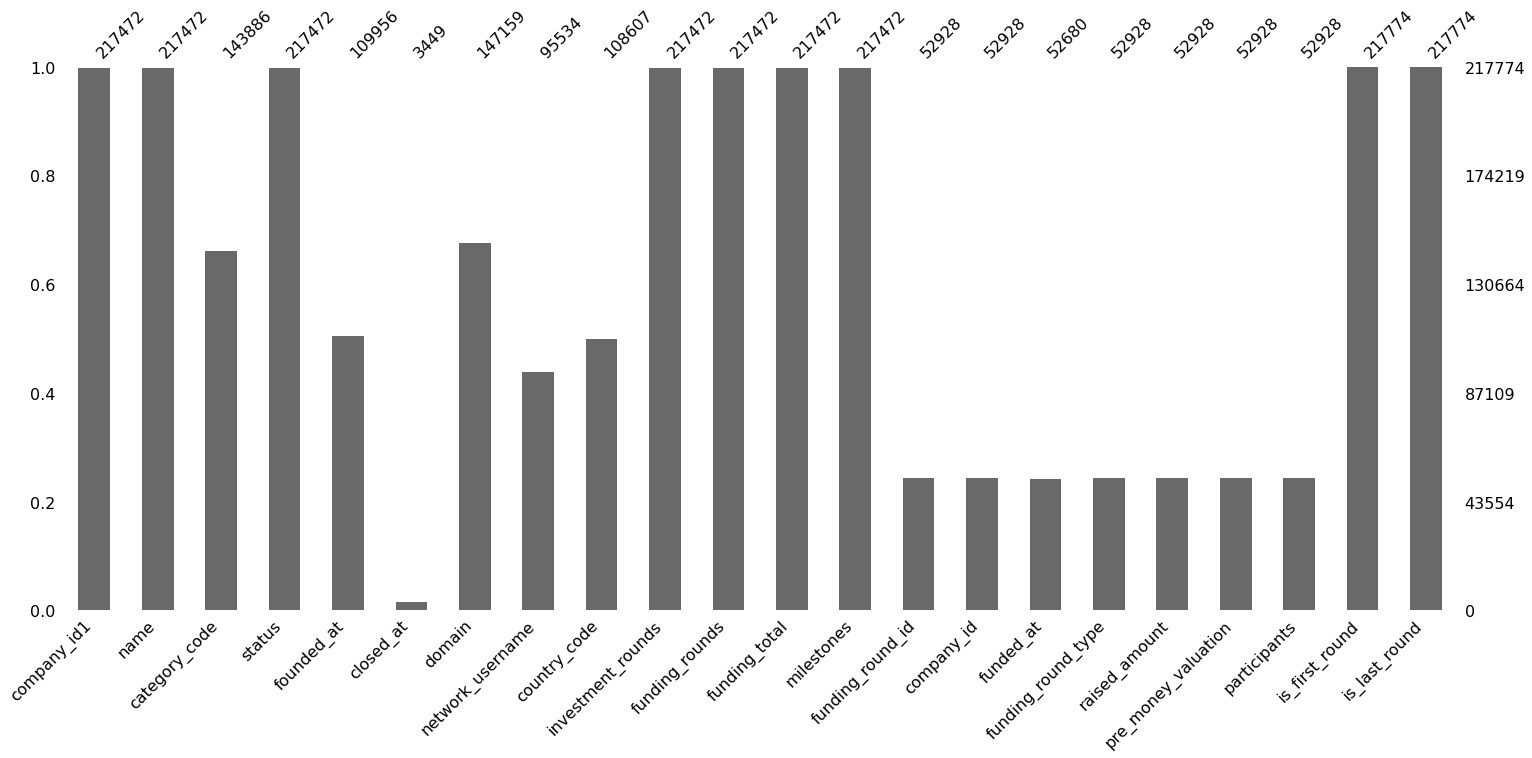

In [19]:
# Изучим датасет company_and_rounds_df на предмет пропусков
msno.bar(company_and_rounds_df)

На столбчатой диаграмме видим большое количество пропусков, особенно во второй половине датасета — одинаковое количество данных (около 80%) пропущено в столбцах funding_round_id, company_id, funded_at, funding_round_type, raised_amount, pre_money_valuation, participants. Изучим подробнее расположение пропусков в датасете.

<AxesSubplot:>

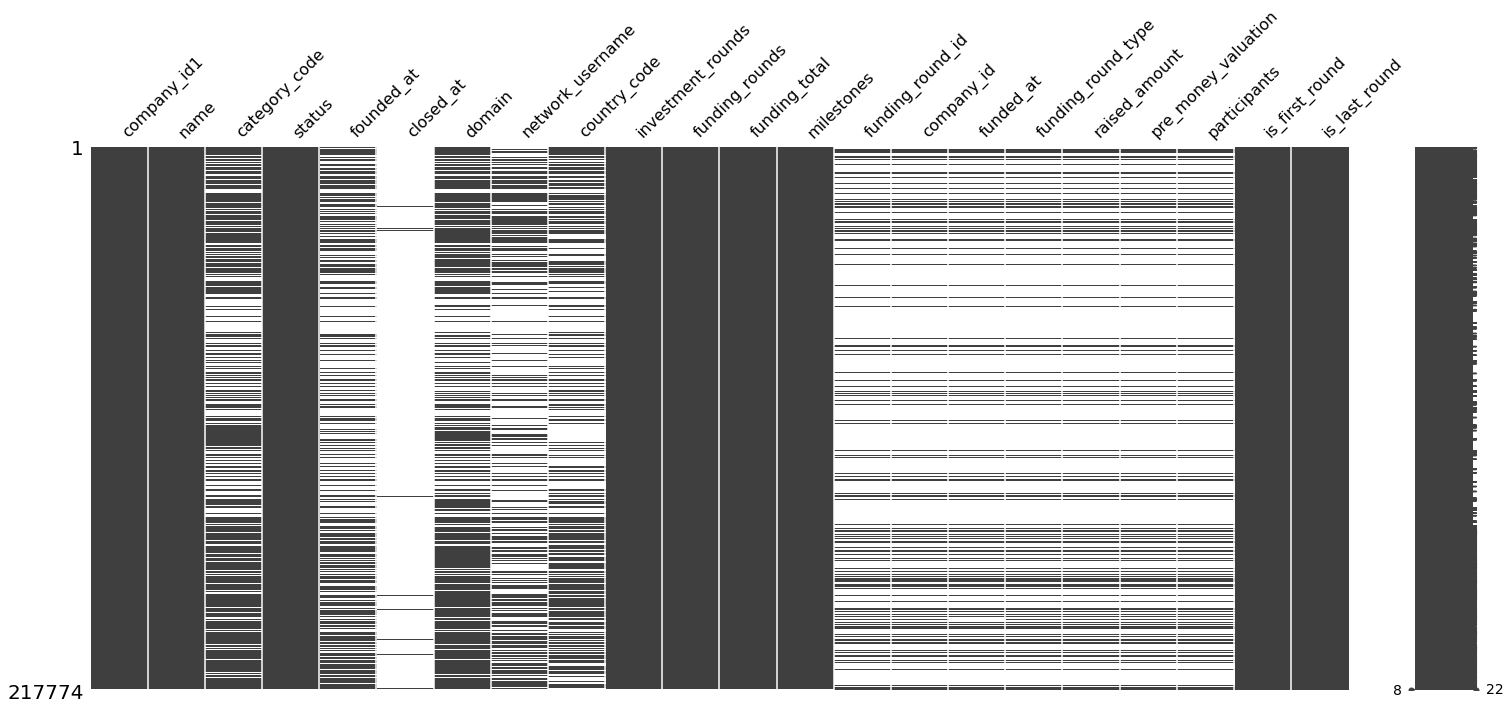

In [20]:
# Построим матрицу для демонстрации закономерности в пропущенных значениях
msno.matrix(company_and_rounds_df)

Согласно матрице, в датасете наблюдается отчетливая закономерность в расположении пропусков во второй половине датасета — пропуски располагаются на одних и тех же места. Скорее всего, это связано с происхождением датасета `company_and_rounds` — было объединено два датасета через «левое» присоединение, где «левой» таблицей была таблица с информацией о компаниях, а «правой» — таблица с информацией о раундах финансирования. Таким образом, в полученном датасете были учтены все компании, но не все из них участвовали в финансировании, или об этом нет информации.

**Поработаем с датасетами `acquisition_df`, `education_df`, `people_df` и `degrees_df`**

In [21]:
# Поменяем типы данных в столбцах term_code и acquired_at
acquisition_df['term_code'] = acquisition_df['term_code'].astype('category')

In [22]:
# Оценим полноту данных в датасете education_df
print(education_df.isna().sum())
print()
print(education_df.isna().mean()*100)

id                  0
person_id           0
institution        55
graduated_at    51556
dtype: int64

id               0.000000
person_id        0.000000
institution      0.050178
graduated_at    47.035854
dtype: float64


In [23]:
# Оценим полноту данных в датасете people_df
print(people_df.isna().sum())
print()
print(people_df.isna().mean()*100)

id                       0
first_name               5
last_name                1
company_id          192094
network_username    187842
dtype: int64

id                   0.000000
first_name           0.002205
last_name            0.000441
company_id          84.731528
network_username    82.855996
dtype: float64


In [24]:
degrees_df.head()

,id,object_id,degree_type,subject
0,1,p:6117,MBA,NaN
1,2,p:6136,BA,"English, French"
2,3,p:6136,MS,Mass Communication
3,4,p:6005,MS,Internet Technology
4,5,p:5832,BCS,"Computer Science, Psychology"


Данные в столбце `object_id`, которые содержат идентификатор сотрудника, представлены в формате `object`. Для того, чтобы далее можно было объединять этот датасет с датасетами `people_df` и `education_df`, необходимо обработать этот столбец (удалить приставку «р:») и поменять тип данных на integer.

In [25]:
# Удалим первые два знака в значениях столбца object_id
degrees_df['object_id'] = degrees_df['object_id'].str[2:]

# Поменяем тип данных в столбце object_id
degrees_df['object_id'] = pd.to_numeric(degrees_df['object_id'])

Судя по предварительной оценке пропущенных значений, можно сделать следующие выводе о полноте данных:
- В датасете `company_and_rounds_df` содержится неполная информация о суммах, дате и раундах финансирования: столбцы `raised_amount`, `funded_at`, `funding_round_id` содержат **76%** пропущенных значений. Поэтому к полученным результатам по задаче 2.1 о раундах финансирования по годам стоит относиться аккуратно.
- Таблица `people_df` демонстрирует, что всего у 15% сотрудников имеется информация о компании, поэтому к результатам задания 2.2 об оценке зависимости полноты информации о сотрудниках от размера компании также надо подходить к осторожностью. Также отсутствует по 47% сотрудников нет информации о годе выпуска. Кроме того, таблица `education_df` содержит в 2 раза меньше сотрудников, чем таблица `people_df`, что также уменьшает объем данных, по которым можно делать выводы.

### Изучим данные на предмет дубликатов

Начнем с проверки явных дубликатов

In [26]:
# Создадим словарь с названиями датафреймов
dfs = {
    'company_and_rounds_df': company_and_rounds_df,
    'acquisition_df': acquisition_df,
    'education_df': education_df,
    'people_df': people_df,
    'degrees_df': degrees_df
}

# Выведем информацию о кол-ве дубликатов с помощью цикла
for name, df in dfs.items():
    print(f'Количество дубликатов в датасете {name}: {df.duplicated().sum()}')

Количество дубликатов в датасете company_and_rounds_df: 0
Количество дубликатов в датасете acquisition_df: 0
Количество дубликатов в датасете education_df: 0
Количество дубликатов в датасете people_df: 0
Количество дубликатов в датасете degrees_df: 0


В данных **нет явных дубликатов**. Теперь перейдем к проверке **неявных дубликатов** — значения id в таблицах должны быть уникальными.

In [27]:
# Посмотрим, сколько в датасете company_and_rounds_df строк с одинаковыми id компаний
company_and_rounds_df.duplicated(subset = 'company_id1').sum()

21220

In [28]:
# Посмотрим на строки с дублирующимися company_id1
company_and_rounds_df[company_and_rounds_df.duplicated(subset = 'company_id1', keep = False)]

,company_id1,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,...,milestones,funding_round_id,company_id,funded_at,funding_round_type,raised_amount,pre_money_valuation,participants,is_first_round,is_last_round
0,1.0,Wetpaint,web,operating,2005-10-17,NaT,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,888.0,1.0,2005-10-01,series-a,5250000.0,0.0,2.0,False,True
1,1.0,Wetpaint,web,operating,2005-10-17,NaT,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,889.0,1.0,2007-01-01,series-b,9500000.0,0.0,3.0,False,False
2,1.0,Wetpaint,web,operating,2005-10-17,NaT,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,2312.0,1.0,2008-05-19,series-c+,25000000.0,0.0,4.0,True,False
21,10015.0,Fitbit,health,operating,2007-10-01,NaT,fitbit.com,fitbit,USA,0.0,...,0.0,3619.0,10015.0,2008-10-10,series-a,2000000.0,0.0,2.0,False,True
22,10015.0,Fitbit,health,operating,2007-10-01,NaT,fitbit.com,fitbit,USA,0.0,...,0.0,18213.0,10015.0,2010-09-10,series-b,9000000.0,0.0,4.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217769,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,56454.0,282847.0,2011-01-31,other,5500000.0,0.0,0.0,True,True
217770,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,56542.0,55477.0,2011-01-13,venture,10633300.0,0.0,0.0,False,True
217771,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,56543.0,55477.0,2012-05-31,venture,2125720.0,0.0,0.0,True,False
217772,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaN,56928.0,283492.0,2013-12-03,venture,3602480.0,0.0,5.0,True,True


В датасете `company_and_rounds_df` найдено 21 220 повторяющихся company_id1. Это не ошибка, поскольку каждая запись соответствует отдельному раунду финансирования компании, и идентификатор компании повторяется при наличии нескольких раундов. Однако при этом общая информация о компаниях дублируется, поэтому имеет смысл разделить данные на два датафрейма: один — с информацией о компаниях, второй — с данными о раундах.

In [29]:
# Создадим словарь с названиями датафреймов
dfs = {
    'acquisition_df': acquisition_df,
    'education_df': education_df,
    'people_df': people_df,
    'degrees_df': degrees_df
}

# Проверим кол-во дубликатов по столбцу id в остальных датасетах
for name, df in dfs.items():
    print(f"Количество дубликатов по столбцу id в датасете {name}: {df.duplicated(subset = 'id').sum()}")

Количество дубликатов по столбцу id в датасете acquisition_df: 0
Количество дубликатов по столбцу id в датасете education_df: 0
Количество дубликатов по столбцу id в датасете people_df: 1
Количество дубликатов по столбцу id в датасете degrees_df: 0


In [30]:
# Познакомимся с дубликатом в датасете people_df
people_df[people_df.duplicated(subset='id', keep=False)]

,id,first_name,last_name,company_id,network_username
13171,116554,Nicole,Couto,200243.0,NaN
13172,116554,Nicole,Couto,212993.0,NaN


В датасете `people_df` также обнаружилось две записи об одном сотруднике. Но, учитывая, что один человек может работать в разных компаниях, этот дубликат не требует обработки. В остальных датасетах нет повторяющихся id. 

Теперь проверим корректность **категориальных значений**, чтобы убедиться, что одинаковые сущности не представлены в данных разными написаниями или вариантами названий.

In [31]:
# Выведем все уникальные объекты в столбце term_code датасета acquisition_df
acquisition_df['term_code'].unique()

[NaN, 'cash', 'stock', 'cash_and_stock']
Categories (3, object): ['cash', 'cash_and_stock', 'stock']

In [32]:
# Выведем все уникальные объекты в столбце category_code датасета company_and_rounds_df
company_and_rounds_df['category_code'].unique().tolist()

['web',
 'games_video',
 'network_hosting',
 'advertising',
 'cleantech',
 nan,
 'enterprise',
 'other',
 'consulting',
 'mobile',
 'health',
 'software',
 'analytics',
 'finance',
 'education',
 'medical',
 'manufacturing',
 'biotech',
 'ecommerce',
 'public_relations',
 'hardware',
 'search',
 'news',
 'government',
 'security',
 'photo_video',
 'travel',
 'semiconductor',
 'social',
 'legal',
 'transportation',
 'hospitality',
 'sports',
 'nonprofit',
 'fashion',
 'messaging',
 'music',
 'automotive',
 'design',
 'real_estate',
 'local',
 'nanotech',
 'pets']

In [33]:
# Выведем все уникальные объекты в столбце status датасета company_and_rounds_df
company_and_rounds_df['status'].unique()

['operating', 'acquired', 'closed', 'ipo', NaN]
Categories (4, object): ['acquired', 'closed', 'ipo', 'operating']

In [34]:
# Выведем все уникальные объекты в столбце funding_round_type датасета company_and_rounds_df
company_and_rounds_df['funding_round_type'].unique()

['series-a', 'series-b', 'series-c+', NaN, 'angel', 'venture', 'other', 'private-equity', 'post-ipo', 'crowdfunding']
Categories (9, object): ['angel', 'crowdfunding', 'other', 'post-ipo', ..., 'series-a', 'series-b', 'series-c+', 'venture']

В обозначениях вариантов расчета, категорий области деятельности компании, статуса компаниий и типа финансирования нет ошибок.

## Шаг 2. Предобработка данных, предварительное исследование


### 2.1. Раунды финансирования по годам

В этом разделе будет проведён анализ динамики финансирования стартапов по годам. Будет рассмотрено, как изменялся типичный размер средств, выделяемых в рамках одного раунда, и общее количество раундов финансирования, а также выявим годы с наибольшими значениями и ключевые тенденции.

In [35]:
# Создадим столбец с годом финансирования на основе столбца funded_at
company_and_rounds_df['funded_at_year'] = company_and_rounds_df['funded_at'].dt.year

# Создадим сводную таблицу по годам с информацией о типичном размере средств, выделяемых в рамках одного раунда и
# общем количестве раундов финансирования за каждый год
summary_table = pd.pivot_table(
    company_and_rounds_df, 
    index = 'funded_at_year', 
    values = 'raised_amount', 
    aggfunc = {'median', 'count'}
).reset_index()

# Оставим только те года, для которых есть информация о более чем 50 раундах финансирования
filtered_table = summary_table[summary_table['count'] > 50]

filtered_table

,funded_at_year,count,median
15,1999.0,76,2000000.0
16,2000.0,125,4200000.0
17,2001.0,96,3000000.0
18,2002.0,116,4200000.0
19,2003.0,159,3000000.0
20,2004.0,291,5000000.0
21,2005.0,1633,5500000.0
22,2006.0,2436,5000000.0
23,2007.0,3279,3973320.0
24,2008.0,3774,3110000.0


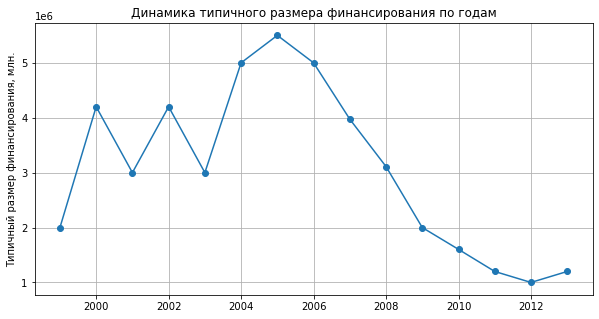

In [36]:
# Построим линейный график для отражения динамики типичного размера финансирования
filtered_table.plot(kind = 'line', 
                    x = 'funded_at_year', 
                    y = 'median', 
                    title = 'Динамика типичного размера финансирования по годам',
                    xlabel = '',
                    ylabel = 'Типичный размер финансирования, млн.',
                    legend = False,
                    figsize = (10, 5),
                    grid = True,
                    marker = 'o')
plt.show()

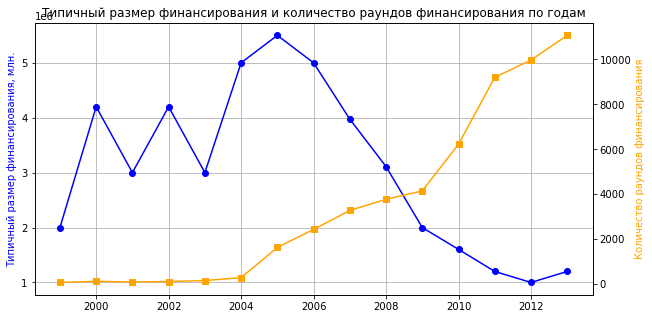

In [37]:
# Построим линейный график для отражения динамики типичного размера финансирования и кол-ва раундов финансирования
fig, ax1 = plt.subplots(figsize=(10, 5))

# Первая линия: медианный размер финансирования
ax1.plot(filtered_table['funded_at_year'], filtered_table['median'], color='blue', marker='o')
ax1.set_xlabel('')
ax1.set_ylabel('Типичный размер финансирования, млн.', color = 'blue')
ax1.tick_params(axis='y')
ax1.grid(True)

# Вторая ось Y для количества раундов финансирования
ax2 = ax1.twinx()
ax2.plot(filtered_table['funded_at_year'], filtered_table['count'], color='orange', marker='s')
ax2.set_ylabel('Количество раундов финансирования', color = 'orange')
ax2.tick_params(axis='y')

# Заголовок
plt.title('Типичный размер финансирования и количество раундов финансирования по годам')

plt.show()

**На основе полученных данных можно сделать следующие выводы:**
- Типичный размер собранных в рамках одного раунда средств был максимален в 2005 году и составлял 5.5 млн. Далее наблюдается резкое снижение вплоть до 2012 года.
- В 1999 - 2005 гг. показатели типичного размера финансирования и количества раундов слабо, но постепенно росли. В 2005 г. медиана финансирования достигла пика и начала резко и неуклонно снижаться, при этом количество раундов финансирования продолжило расти. В 2013 году наблюдалось некоторое увеличение типичного размера финансирования, но этот показатель далек от значений прошлых лет. Что касается тенденции 2005-2012 гг., можно предположить, что в это время инвесторы стали более осторожными и предпочитали диверсифицировать свои инвестиции — меньшие суммы в большее количество компаний.



### 2.2. Сотрудники и их образование

**Цель раздела** — определить, зависит ли полнота сведений о сотрудниках (например, об их образовании) от размера компаний.

Для достижения этой цели планируется:
- Разделить компании на группы по численности сотрудников и рассчитать среднюю долю сотрудников без данных об образовании в каждой группе.
- Определить набор таблиц, необходимых для проведения анализа.

Информация о сотрудниках содержится в таблицах `people_df`, `education_df` и `degrees_df`. 

В таблице `people_df` содержится информация о месте работы сотрудника (`company_id`), в `education_df` — об университете (`institution`). Этой информации достаточно для достижения цели раздела, поэтому присоединение таблицы `degrees_df` представляется изыбточным.

In [38]:
# Объединим таблицы people_df и education_df
people_education_df = people_df.merge(education_df, how = 'left', left_on = 'id', right_on = 'person_id')

In [39]:
# Изучим общую информацию о полученном датасете
people_education_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267694 entries, 0 to 267693
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id_x              267694 non-null  int64         
 1   first_name        267689 non-null  object        
 2   last_name         267693 non-null  object        
 3   company_id        44789 non-null   float64       
 4   network_username  50775 non-null   object        
 5   id_y              109056 non-null  float64       
 6   person_id         109056 non-null  float64       
 7   institution       109002 non-null  object        
 8   graduated_at      57691 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 20.4+ MB


Видим, что новый датасет содержит 267 694 строк, хотя в таблице `people_df` содержится информация всего о 226 709 сотрудниках — это отражает наличие нескольких образований у некоторых сотрудников.

Поскольку для целей исследования необходимы данные только о самом факте наличия информации об образовании, а конкретные данные (например, о годе выпуска, учебном заведении, типе образования и т.п.) не нужны, имеет смысл удалить строки-дубликаты, которые отражают несколько вариантов образования для одного и того же сотрудника. Это позволит избежать дублирующейся информации и не учитывать в расчетах одного сотрудника несколько раз.

In [40]:
# Удалим «дубликаты»
people_education_df.drop_duplicates(subset = 'id_x', inplace = True)

In [41]:
# Проверим результат
people_education_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226708 entries, 0 to 267693
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id_x              226708 non-null  int64         
 1   first_name        226703 non-null  object        
 2   last_name         226707 non-null  object        
 3   company_id        34614 non-null   float64       
 4   network_username  38867 non-null   object        
 5   id_y              68071 non-null   float64       
 6   person_id         68071 non-null   float64       
 7   institution       68031 non-null   object        
 8   graduated_at      36387 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 17.3+ MB


В датасете `people_education_cleaned` осталось по одной записи на каждого сотрудника. Теперь с этими данными можно работать далее.

Создадим новый столбец `is_education` с информацией о наличии или отсутствии информации об образовании

In [42]:
# Создадим столбец is_education, где 1 будет означать наличие информации об образовании, а 0 — ее отсутствие
people_education_df['is_education'] = (
    people_education_df['institution'].notna() | 
    people_education_df['graduated_at'].notna()
).astype(int)

Перейдем непосредственно к задаче об оценке зависимости между размером компании и полнотой сведений об образовании сотрудников

In [43]:
# Оценим информацию о количестве сотрудников в каждой компании
companies = pd.DataFrame(people_education_df.groupby('company_id')['id_x'].count())
companies['id_x'].value_counts()

1      18116
2       2709
3        921
4        450
5        237
6        138
7        100
8         59
9         46
11        30
10        25
13        17
12        16
14         8
17         5
16         4
23         3
19         3
20         3
18         3
15         3
29         2
25         2
56         2
22         2
21         2
31         1
138        1
35         1
47         1
32         1
39         1
63         1
36         1
51         1
48         1
244        1
61         1
150        1
26         1
72         1
Name: id_x, dtype: int64

В данных наблюдается неравномерное распределение — большое количество малых компаний (до 14 сотрудников) и маленькое количество более крупных компаний. 

In [44]:
# Создадим новый столбец company_size с группами по количеству сотрудников
bins   = [0, 1, 2, 3, 5, 10, 25, float('inf')]
labels = ['1', '2', '3', '4-5', '6-10', '11-25', '26+']
companies['company_size'] = pd.cut(companies['id_x'], bins=bins, labels=labels)

In [45]:
# Посмотрим на получившиеся группы и количество компаний, попавших в эти группы
companies['company_size'].value_counts()

1        18116
2         2709
3          921
4-5        687
6-10       368
11-25      101
26+         19
Name: company_size, dtype: int64

In [46]:
# Присоединяем информацию о типе компании к исходной таблице people_education_df
people_education_df = people_education_df.merge(companies, how = 'left', on = 'company_id')

In [47]:
# Определяем среднюю долю сотрудников без информации об образовании в каждой из групп
1 - people_education_df.groupby('company_size')['is_education'].mean()

company_size
1        0.462630
2        0.466224
3        0.487152
4-5      0.499162
6-10     0.533784
11-25    0.456842
26+      0.272727
Name: is_education, dtype: float64

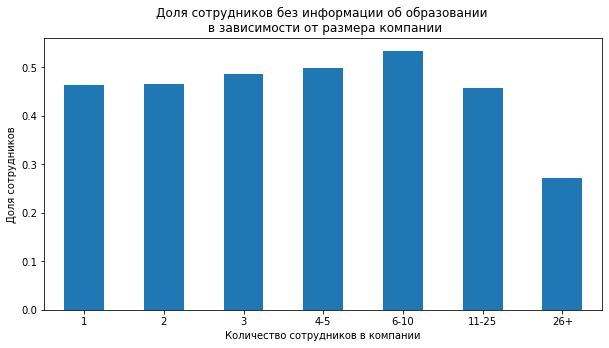

In [48]:
# Построим столбчатую диаграмму для демонстрации различий
(1 - people_education_df.groupby('company_size')['is_education'].mean()).plot(
    kind = 'bar',
    rot = 0,
    title = 'Доля сотрудников без информации об образовании \n в зависимости от размера компании',
    xlabel = 'Количество сотрудников в компании',
    ylabel = 'Доля сотрудников',
    figsize = (10, 5))

plt.show()

В компаниях с числом сотрудников от 1 до 10 наблюдается умеренная тенденция к увеличению доли сотрудников без информации об образовании по мере роста размера компании — от 46% до 53%. Однако начиная с группы компаний с численностью от 11 сотрудников и выше, эта тенденция меняется на противоположную: доля сотрудников без данных об образовании начинает снижаться и достигает минимума (27%) в крупных компаниях (26+).

Таким образом, можно сделать вывод, что в наиболее крупных компаниях образовательные данные сотрудников представлены наиболее полно, в то время как в малых и микропредприятиях наблюдается нехватка информации и менее выраженные различия между группами.

Однако стоит учитывать следующие ограничения, которые заставляют с осторожностью смотреть на полученные результаты:
- Используется не реальная информация о количестве сотрудников в компаниях, а синтетическая — учитывались только сотрудники, имеющиеся в базе данных.
- Распределение количества компаний в группах неравномерное, т.к. в датасете в основном представлены компании с небольшим количеством сотрудников.

### 2.3. Объединять или не объединять — вот в чём вопрос

В этом разделе предстоит проверить, можно ли использовать столбцы с именем `network_username` для объединения данных.

Столбец с именем `network_username` встречается в двух датасетах: `company_and_rounds_df`, `people_df`.

Согласно описанию данных, столбец `network_username` в датасете `company_and_rounds_df` содержит ники компании в сети, а в датасете `people_df` — ники сотрудников. Поэтому маловероятно, что эти данные дублируют друг друга. Однако стоит проверить пересечения.

In [49]:
# Удалим пропуски перед использованием set и сразу сделаем копию
clean_company = company_and_rounds_df.dropna(subset=['network_username']).copy()
clean_people = people_df.dropna(subset=['network_username']).copy()

# Приведем данные к одному регистру
clean_company['network_username'] = clean_company['network_username'].str.lower()
clean_people['network_username'] = clean_people['network_username'].str.lower()

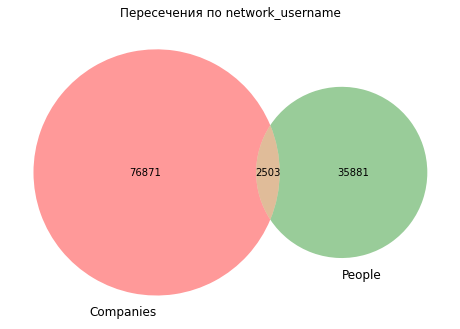

Доля общего пересечения: 2.17%


In [50]:
#! pip install matplotlib_venn
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Превратим колонки в множества
company_users = set(clean_company['network_username'])
people_users = set(clean_people['network_username'])

# Строим диаграмму Венна для двух множеств
plt.figure(figsize=(8, 8))
venn2([company_users, people_users],
      set_labels=('Companies', 'People'))
plt.title("Пересечения по network_username")
plt.show()

# Дополнительно выведем относительные значения
total_unique = len(company_users | people_users)
print(f"Доля общего пересечения: {len(company_users & people_users) / total_unique:.2%}")


Согласно диаграмме Венна, пересечение значений по столбцу `network_username` между датасетами `company_and_rounds_df` и `people_df` составило всего `2 503` записи (`2,17%` от общего числа уникальных значений). Вероятнее всего, это случайные совпадения, когда ники компаний и отдельных сотрудников оказались одинаковыми. Поэтому **использовать этот столбец для объединения данных нецелесообразно**.

### 2.4. Проблемный датасет и причина возникновения пропусков

В датасете `company_and_rounds_df` ранее было выявлено значительное количество пропусков в информации о раундах финансирования — ключевых для заказчика данных. 

В этом разделе датасет будет преобразован в более удобный для анализа формат, который позволит в дальнейшем проводить анализ в разрезе отдельных компаний без необходимости дополнительных агрегаций.

In [51]:
# Изучим данные в датасете company_and_rounds_df
company_and_rounds_df.head()

,company_id1,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,...,funding_round_id,company_id,funded_at,funding_round_type,raised_amount,pre_money_valuation,participants,is_first_round,is_last_round,funded_at_year
0,1.0,Wetpaint,web,operating,2005-10-17,NaT,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,888.0,1.0,2005-10-01,series-a,5250000.0,0.0,2.0,False,True,2005.0
1,1.0,Wetpaint,web,operating,2005-10-17,NaT,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,889.0,1.0,2007-01-01,series-b,9500000.0,0.0,3.0,False,False,2007.0
2,1.0,Wetpaint,web,operating,2005-10-17,NaT,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,2312.0,1.0,2008-05-19,series-c+,25000000.0,0.0,4.0,True,False,2008.0
3,10.0,Flektor,games_video,acquired,NaT,NaT,flektor.com,NaN,USA,0.0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
4,100.0,There,games_video,acquired,NaT,NaT,there.com,NaN,USA,0.0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN


В данных обнаружено несоответствие между значениями в столбцах `is_first_round` и `is_last_round`, которые указывают, является ли конкретный раунд первым или последним для компании. В некоторых случаях, судя по хронологии дат в `funded_at`, эти признаки выставлены неверно: первые раунды помечены как последние, и наоборот. Это искажает дальнейший анализ и требует корректировки значений.

In [52]:
# «Поменяем местами» столбцы is_first_round и is_last_round
first_round_copy = company_and_rounds_df['is_first_round'].copy()
company_and_rounds_df['is_first_round'] = company_and_rounds_df['is_last_round']
company_and_rounds_df['is_last_round'] = first_round_copy

<AxesSubplot:>

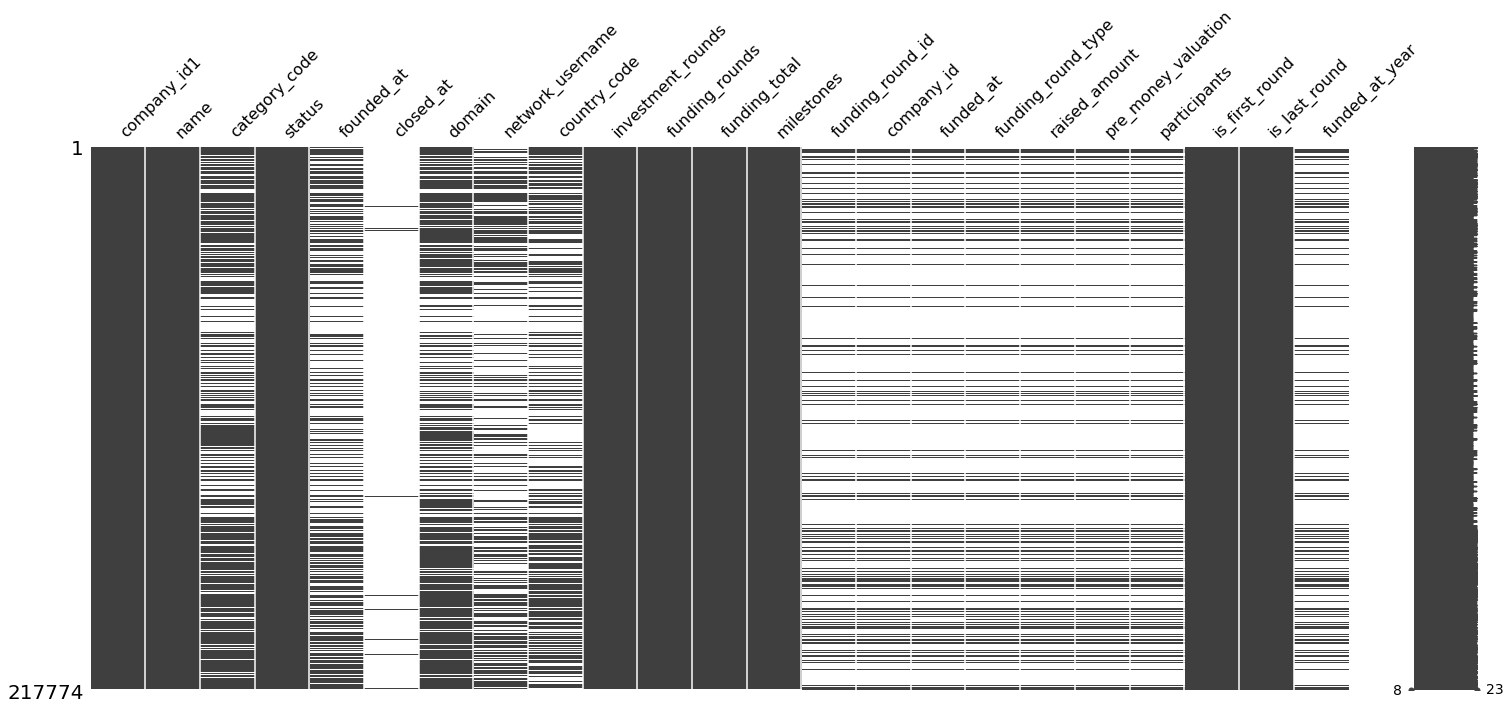

In [53]:
# Продублируем матрицу для демонстрации закономерности в пропущенных значениях
msno.matrix(company_and_rounds_df)

Вероятно, датасет `company_and_rounds.csv` был образован при объединении двух датасетов с помощью ключа `company_id`: в одном содержалась информация о компаниях, во втором — информация о раундах финансирования. Разделим этот датасет на два.

1. Создадим датафрейм `companies_df` с информацией о компаниях

In [54]:
# Создадим датафрейм companies_df с информацией о компаниях
companies_df = company_and_rounds_df.iloc[:, :13]

# Переименуем столбец company_id1, т.к. он больше не дублируется
companies_df.rename(columns = {'company_id1': 'company_id'}, inplace = True)

In [55]:
# Проверим новый датафрейм на явные дубликаты
companies_df.duplicated().sum()

21220

Обнаружилось 21 220 полных дубликатов. Удалим их

In [56]:
# Удалим дубликаты из датасета companies_df
companies_df = companies_df.drop_duplicates()

companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196554 entries, 0 to 217472
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   company_id         196553 non-null  float64       
 1   name               196553 non-null  object        
 2   category_code      123186 non-null  category      
 3   status             196553 non-null  category      
 4   founded_at         91227 non-null   datetime64[ns]
 5   closed_at          2620 non-null    datetime64[ns]
 6   domain             126545 non-null  object        
 7   network_username   80591 non-null   object        
 8   country_code       87990 non-null   object        
 9   investment_rounds  196553 non-null  float64       
 10  funding_rounds     196553 non-null  float64       
 11  funding_total      196553 non-null  float64       
 12  milestones         196553 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(5

В итоге имеем информацию о 196 553 компаниях.

2. Создадим датафрейм `rounds_df` с информацией о раундах финансирования

In [57]:
# Создадим датафрейм rounds_df с информацией о раундах финансирования
rounds_df = company_and_rounds_df.iloc[:, 13:]

In [58]:
# Проверим новый датафрейм на явные дубликаты
rounds_df.duplicated().sum()

164845

Обнаружилось 164 845 дубликатов, посмотрим на них подробнее.

In [59]:
# Сортируем датафрейм по всем столбцам
df_sorted = rounds_df.sort_values(by=rounds_df.columns.tolist())

# Находим дубликаты
duplicates = df_sorted[df_sorted.duplicated(keep=False)]

# Выводим дубликаты
duplicates

,funding_round_id,company_id,funded_at,funding_round_type,raised_amount,pre_money_valuation,participants,is_first_round,is_last_round,funded_at_year
3,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
4,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
5,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
6,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
7,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...
217457,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
217460,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
217461,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN
217462,NaN,NaN,NaT,NaN,NaN,NaN,NaN,True,True,NaN


Оказалось, что дубликаты — это строки, практически полностью заполненные нулевыми значениями. Удалим такие строки, т.к. они не несут никакой полезной информации для дальнейшего анализа.

In [60]:
rounds_df = rounds_df.drop_duplicates()

In [61]:
rounds_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52929 entries, 0 to 217773
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   funding_round_id     52928 non-null  float64       
 1   company_id           52928 non-null  float64       
 2   funded_at            52680 non-null  datetime64[ns]
 3   funding_round_type   52928 non-null  category      
 4   raised_amount        52928 non-null  float64       
 5   pre_money_valuation  52928 non-null  float64       
 6   participants         52928 non-null  float64       
 7   is_first_round       52929 non-null  bool          
 8   is_last_round        52929 non-null  bool          
 9   funded_at_year       52680 non-null  float64       
dtypes: bool(2), category(1), datetime64[ns](1), float64(6)
memory usage: 3.4 MB


Теперь имеем данные о 52 928 уникальных раундах финансирования

В результате датафрейм `company_and_rounds_df` был разделен на два: `companies_df` с информацией о компаниях и `rounds_df` с информацией о раундах финансирования. Далее в каждом новом датафрейме были удалены явные дубликаты, которые появились в процессе разделения.


## Шаг 3. Исследовательский анализ объединённых таблиц


### 3.1. Объединение данных

Предстоит сформировать объединённую таблицу для ответа на вопросы заказчика, которые касаются интересующих его компаний. Заказчика прежде всего интересуют те компании, которые меняли или готовы менять владельцев. Получение инвестиций или финансирования, по мнению заказчика, означает интерес к покупке или продаже компании.

Для этого из датасета `companies_df` будут отобраны только те компании, у которых количество раундов финансирования (`funding_rounds` или `investment_rounds`) больше нуля, либо в колонке `status` указано значение `acquired`. Итоговая выборка послужит основой для дальнейшего объединения с другими источниками данных.

In [62]:
# Отфильтруем таблицу companies_df
companies_filtered = companies_df[(companies_df['funding_rounds'] >0) | 
                                  (companies_df['investment_rounds'] > 0) | 
                                  (companies_df['status'] == 'acquired')]

In [63]:
companies_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40747 entries, 0 to 217469
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_id         40747 non-null  float64       
 1   name               40747 non-null  object        
 2   category_code      35315 non-null  category      
 3   status             40747 non-null  category      
 4   founded_at         27807 non-null  datetime64[ns]
 5   closed_at          2128 non-null   datetime64[ns]
 6   domain             35754 non-null  object        
 7   network_username   20850 non-null  object        
 8   country_code       34742 non-null  object        
 9   investment_rounds  40747 non-null  float64       
 10  funding_rounds     40747 non-null  float64       
 11  funding_total      40747 non-null  float64       
 12  milestones         40747 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(5), object(4)
mem

В результате фильтрации получили таблицу `companies_filtered` с 40 747 компаниями. На первый взгляд, фильтрация прошла корректно.


### 3.2. Анализ выбросов

В этом разделе рассматривается типичный размер общего финансирования, получаемого одной компанией за выбранный период, а также выявляются выбивающиеся значения. Для анализа используется столбец `funding_total`. Оценка распределения значений будет проведена с помощью графических методов, чтобы визуально определить характерные и аномальные объёмы финансирования.

In [64]:
# Посмотрим, есть ли пропуски в столбце funding_total
companies_filtered['funding_total'].isna().sum()

0

In [65]:
companies_filtered.head()

,company_id,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,funding_rounds,funding_total,milestones
0,1.0,Wetpaint,web,operating,2005-10-17,NaT,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0
3,10.0,Flektor,games_video,acquired,NaT,NaT,flektor.com,NaN,USA,0.0,0.0,0.0,0.0
4,100.0,There,games_video,acquired,NaT,NaT,there.com,NaN,USA,0.0,0.0,0.0,4.0
15,1001.0,FriendFeed,web,acquired,2007-10-01,NaT,friendfeed.com,friendfeed,USA,0.0,1.0,5000000.0,3.0
20,10014.0,Mobclix,mobile,acquired,2008-03-01,NaT,mobclix.com,mobclix,USA,0.0,1.0,0.0,4.0


В столбце `funding_total` отсутствуют пропуски, однако присутствуют строки со значением 0. Поскольку такие значения могут искажать результаты анализа, их целесообразно заменить на NaN, чтобы исключить из расчётов некорректные данные.

In [66]:
# Заменим все нулевые значения в столбце funding_total на NaN
companies_filtered = companies_filtered.copy()
companies_filtered['funding_total'] = companies_filtered['funding_total'].replace(0, np.nan)

In [67]:
companies_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40747 entries, 0 to 217469
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company_id         40747 non-null  float64       
 1   name               40747 non-null  object        
 2   category_code      35315 non-null  category      
 3   status             40747 non-null  category      
 4   founded_at         27807 non-null  datetime64[ns]
 5   closed_at          2128 non-null   datetime64[ns]
 6   domain             35754 non-null  object        
 7   network_username   20850 non-null  object        
 8   country_code       34742 non-null  object        
 9   investment_rounds  40747 non-null  float64       
 10  funding_rounds     40747 non-null  float64       
 11  funding_total      27874 non-null  float64       
 12  milestones         40747 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(5), object(4)
mem

В результате получаем датасет с 27 874 ненулевыми значениями в столбце `funding_total`, остальная часть — пропуски, полученные в результате замены нулевых значений на NaN.

In [68]:
# Выведем основную статистику по столбцу funding_total
companies_filtered['funding_total'].describe()

count    2.787400e+04
mean     1.481652e+07
std      6.775936e+07
min      2.910000e+02
25%      5.000000e+05
50%      2.564500e+06
75%      1.100000e+07
max      5.700000e+09
Name: funding_total, dtype: float64

Результаты метода .describe() демонстрируют наличие большого количества выбросов, значительно отличающихся от типичных значений.

Среднее значение составляет 14,8 млн, однако медиана — всего 2,56 млн, что почти в 7 раз меньше. Это свидетельствует о смещённости распределения и наличии крайне высоких значений, искажающих среднее. Значение стандартного отклонения — 67,8 млн — также указывает на большой разброс. Минимальное значение — 291, а максимальное — 5,7 млрд, что является явным выбросом.

Если ориентироваться на межквартильный размах (от 25% до 75%), то типичный объём общего финансирования для одной компании находится в диапазоне от 500 000 до 11 000 000. Именно в этом диапазоне сосредоточена основная масса наблюдений.

При таких значениях построение гистограммы с линейной шкалой будет малоинформативным, поскольку экстремально большие выбросы сильно сжимают основную часть распределения и делают детали в нижнем диапазоне почти невидимыми. Аналогично, классический boxplot также теряет смысл из-за выраженной асимметрии данных.

Поэтому для более наглядного и адекватного отображения распределения общего финансирования компаний используется гистограмма с логарифмической шкалой, которая позволяет «сжать» большой разброс значений и одновременно показать структуру данных в широком диапазоне — от небольших сумм до крупных инвестиций.

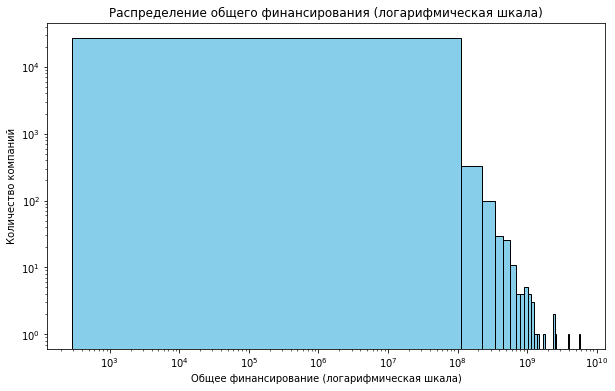

In [69]:
# Построим гистограмму распредления по столбцу funding_total с логарифмической шкалой
plt.figure(figsize=(10, 6))
plt.hist(companies_filtered['funding_total'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.xscale('log')  # Логарифмическая шкала по оси X
plt.xlabel('Общее финансирование (логарифмическая шкала)')
plt.ylabel('Количество компаний')
plt.title('Распределение общего финансирования (логарифмическая шкала)')
plt.show()

Гистограмму с логарифмической шкалой можно дополнить боксплотом с исключением выбросов — это позволит более наглядно отследить медиану, первый и третий квартиль (25-й и 75-й процентили), а также диапазон «усов», которые показывают границы данных без учёта выбросов.

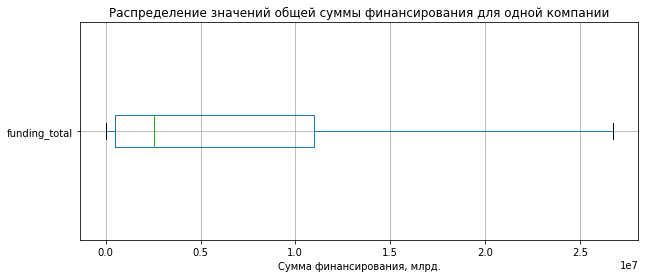

In [70]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 4))

# Строим диаграмму размаха значений в столбце funding_total, исключая выбросы
companies_filtered.boxplot(column='funding_total', vert=False, showfliers=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений общей суммы финансирования для одной компании')
plt.xlabel('Сумма финансирования, млрд.')

# Выводим график
plt.show()

Гистограмма с логарифмической шкалой и boxplot показывают, что большая часть компаний имеет объём финансирования в диапазоне от нескольких сотен тысяч до нескольких десятков миллионов. Значения выше этого уровня встречаются значительно реже и представлены узкими столбцами, отражая редкие, но крупные сделки.


### 3.3. Куплены забесплатно?

В данных есть компании, которые были проданы за ноль или за один доллар, и при этом известно, что у них был ненулевой общий объём финансирования. Следует изучить их поподробнее.

Также будут рассмотрены верхняя и нижняя границы выбросов для столбца `funding_total` для этих компаний.

In [71]:
# Объединим датасеты acquisition_df и companies_filtered
acquired_companies = pd.merge(companies_filtered, acquisition_df, how = 'left', left_on = 'company_id', right_on = 'acquired_company_id')

После объединения имеет смысл проверить датасет на дубликаты в столбце `company_id`.

In [72]:
# Посчитаем количество дубликатов по столбцу company_id в таблице acquired_companies
acquired_companies.duplicated(subset='company_id').sum()

143

In [73]:
# Изучим дублирующиеся строки
duplicates = acquired_companies[acquired_companies.duplicated(subset='company_id', keep=False)]
duplicates.head()

,company_id,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,funding_rounds,funding_total,milestones,id,acquiring_company_id,acquired_company_id,term_code,price_amount,acquired_at
482,10963.0,TNC,web,acquired,2004-01-01,NaT,tnccompany.com,NaN,NaN,0.0,1.0,NaN,2.0,542.0,59.0,10963.0,NaN,0.0,2008-09-12
483,10963.0,TNC,web,acquired,2004-01-01,NaT,tnccompany.com,NaN,NaN,0.0,1.0,NaN,2.0,2484.0,59.0,10963.0,NaN,0.0,2008-09-12
717,11716.0,Hotjobs,NaN,acquired,NaT,NaT,NaN,NaN,NaN,0.0,0.0,NaN,3.0,2985.0,1735.0,11716.0,cash,225000000.0,2010-02-03
718,11716.0,Hotjobs,NaN,acquired,NaT,NaT,NaN,NaN,NaN,0.0,0.0,NaN,3.0,9033.0,29.0,11716.0,cash,436000000.0,2002-01-11
818,11943.0,Opusforum.org,NaN,acquired,NaT,NaT,NaN,NaN,DEU,0.0,0.0,NaN,0.0,633.0,20.0,11943.0,NaN,0.0,2005-06-30


Было обнаружено 143 дубликата в столбце `company_id`. Их появление связано с тем, что в присоединённой таблице `acquisition_df` идентификаторы компаний могут встречаться несколько раз: компания может продаваться или покупать другие компании неоднократно. Поскольку для текущей задачи нас интересуют прежде всего сами сделки, а не компании, эти дубликаты удалять не стоит.

Теперь перейдем к изучению компаний, которые были проданы за ноль или за один доллар, и при этом имели ненулевой общий объём финансирования.

In [74]:
# Отфильтруем нужные строки
acquired_companies_free = acquired_companies[((acquired_companies['price_amount'] == 0) |
                                              (acquired_companies['price_amount'] == 1)) &
                                              (acquired_companies['funding_total'].notna())]

In [75]:
# Выведем статистику по столбцу funding_total в отфильтрованной таблице
acquired_companies_free['funding_total'].describe()

count    1.618000e+03
mean     1.815296e+07
std      1.445030e+08
min      3.750000e+03
25%      2.000000e+06
50%      6.000000e+06
75%      1.550000e+07
max      5.700000e+09
Name: funding_total, dtype: float64

В целом, в отфильтрованной таблице с «бесплатными» компаниями тенденции в распределении значений сумм финансирования сохраняются — наблюдается большой разрыв между средним значением и медианой, а также большое стандратное отклонение, что говорит о наличии большого количества выбросов.

Теперь посчитаем верхнюю и нижнюю границу выбросов. Выбросами считаются значения, которые выходят за границы, определённые по формуле: `Q1 − 1.5 × IQR, Q3 + 1.5 × IQR`. Эти границы рассчитываются на основе межквартильного размаха (IQR).

In [77]:
# Вычисляем квартили Q1 и Q3
Q1 = acquired_companies_free['funding_total'].quantile(0.25)
Q3 = acquired_companies_free['funding_total'].quantile(0.75)

# Вычисляем межквартильный размах IQR
IQR = Q3 - Q1

# Определяем верхнюю и нижнюю границы выбросов
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
lower_bound = max(0, lower_bound)

display (f'Верхняя граница выбросов: {upper_bound}')
display (f'Нижняя граница выбросов: {lower_bound}')

'Верхняя граница выбросов: 35750000.0'

'Нижняя граница выбросов: 0'

In [79]:
data = acquired_companies['funding_total'].dropna()

percentile = percentileofscore(data, upper_bound, kind='weak')

print(f'Верхняя граница выбросов соответствует {percentile:.2f}-му процентилю.')

Верхняя граница выбросов соответствует 90.75-му процентилю.


Верхняя граница выбросов составляет 35 750 000 и соответствует 90.75-му процентилю — то есть 90.75% значений в столбце `funding_total` находятся ниже этой величины. Значения выше этой границы можно считать выбросами.

Нижняя граница выбросов, рассчитанная по формуле, оказалась отрицательной (−18 250 000), однако в контексте анализа финансирования такие значения не имеют смысла — финансирование не может быть отрицательным. Поэтому все значения от 0 до 35 750 000 выбросами не считаются.

В итоге, при анализе выбросами считаются только значения, превышающие верхнюю границу — то есть выше 35,75 млн долларов.

Удалим одно явно аномальное значение 5,7 млрд. и построим boxplot.

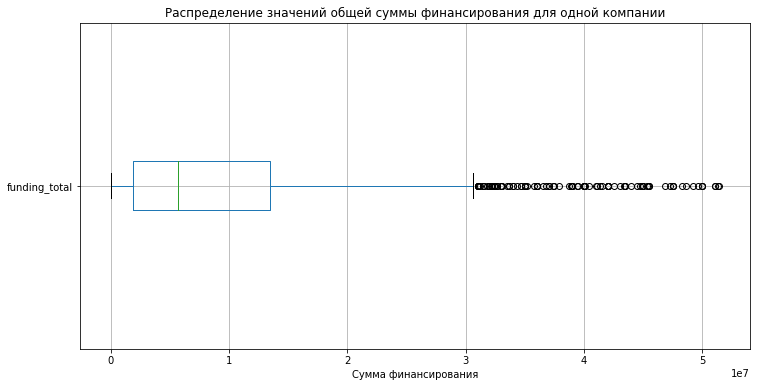

In [222]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 6))

# Исключим явные выбросы для построения boxplot
q95 = acquired_companies_free['funding_total'].quantile(0.95)

# Строим диаграмму размаха значений в столбце balance
acquired_companies_free[acquired_companies_free['funding_total'] <= q95].boxplot(column='funding_total', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений общей суммы финансирования для одной компании')
plt.xlabel('Сумма финансирования')

# Выводим график
plt.show()


### 3.4. Цены стартапов по категориям

Важная часть исследования — выявить категории стартапов, которые могут быть особенно интересны крупным инвесторам. Наибольший инвестиционный интерес часто вызывают проекты с высокими типичными ценами покупки и значительным разбросом стоимости, что предполагает как высокий риск, так и возможность крупной прибыли. В этом разделе будут определены категории стартапов, сочетающие оба этих признака.

Подготовим данные к дальнейшему анализу — во избежание искажения данных исключим сделки с нулевыми суммами и уберем значения выше 90-го перцентиля в столбце `price_amount`.

In [80]:
# Исключим из анализа сделки с нулевыми суммами 
acquired_companies = acquired_companies[acquired_companies['price_amount'] != 0]

In [81]:
# Убираем из столбца price_amount сильные выбросы — значения выше 90 процентиля
percentile_90 = acquired_companies['price_amount'].quantile(0.9)
acquired_companies = acquired_companies[acquired_companies['price_amount'] < percentile_90]

In [82]:
# Посмотрим на распределение числа компаний по категориям
acquired_companies['category_code'].value_counts()

software            363
web                 239
biotech             226
mobile              106
enterprise           98
games_video          82
advertising          76
hardware             73
other                72
semiconductor        64
public_relations     63
network_hosting      56
ecommerce            46
cleantech            34
security             31
consulting           30
search               17
finance              16
manufacturing        14
news                  9
health                8
education             6
hospitality           6
messaging             5
social                4
medical               4
travel                4
photo_video           4
real_estate           4
music                 3
analytics             3
fashion               3
transportation        2
sports                1
automotive            1
nanotech              1
local                 1
design                0
legal                 0
pets                  0
nonprofit             0
government      

В данном контексте нас интересуют типичные цены покупки и величина разброса цен, которые статистически выражаются через медиану и стандартное отклонение соответственно. Медиана отражает типичную цену приобретения, устойчива к выбросам и показывает, какие категории стартапов чаще всего имеют высокую оценку. Стандартное отклонение, в свою очередь, позволяет оценить, насколько сильно варьируются цены внутри каждой категории

In [83]:
# Сгруппируем данные по категориям стартапов и рассчитаем для каждой категории медиану и среднее
categories = acquired_companies.groupby('category_code')['price_amount'].agg(['median', 'std', 'count'])

# Исключим категории с числом компаний менее 30
categories = categories[categories['count'] >= 30]

# Отсортируем таблицу по убыванию медианы
categories.sort_values(by = 'median', ascending = False)

,median,std,count
category_code,,,
cleantech,162500000.0,1.444089e+08,34
security,148500000.0,2.149933e+08,31
biotech,120750000.0,2.138114e+08,226
ecommerce,105000000.0,1.800376e+08,46
semiconductor,75000000.0,1.350668e+08,64
network_hosting,64115000.0,1.804666e+08,56
advertising,50000000.0,1.663535e+08,76
hardware,50000000.0,1.983578e+08,73
other,50000000.0,1.652277e+08,72


Для выявления категорий стартапов, привлекательных для крупных инвесторов, данные были сгруппированы по столбцу `category_code` и по каждой категории были рассчитаны медиана и стандартное отклонение цены покупки (`price_amount`). При этом были исключены категории с числом компаний менее 30.

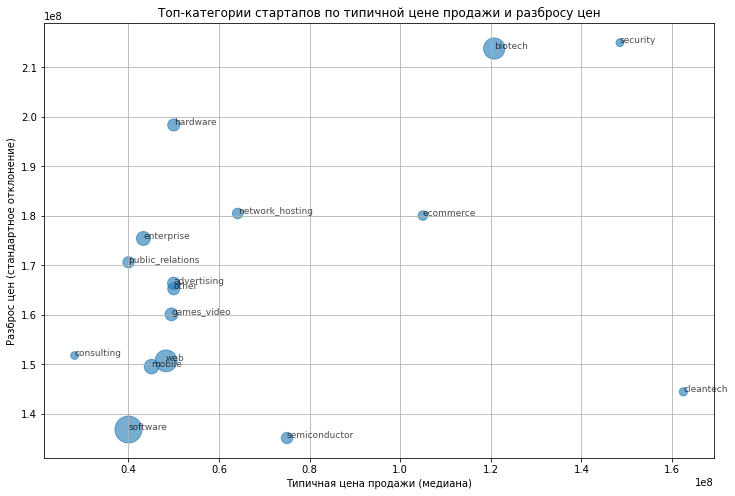

In [84]:
# Построим диаграмму рассеяния для выявления категорий стартапов с высокими типичными ценами и большим разбросом цен
categories = categories.reset_index()
categories.plot(kind = 'scatter',
                x = 'median',
                y = 'std',
                s = categories['count'] * 2, # задаем размеры точек в зависимости от количества компаний в категории
                alpha = 0.6,
                title = 'Топ-категории стартапов по типичной цене продажи и разбросу цен',
                xlabel = 'Типичная цена продажи (медиана)',
                ylabel = 'Разброс цен (стандартное отклонение)',
                figsize = (12,8))

# Добавим подписи к точкам
for i, code in enumerate(categories['category_code']):
    plt.text(
        categories['median'].iloc[i],
        categories['std'].iloc[i],
        code,
        fontsize=9,
        alpha=0.7)
    
plt.grid(True)
plt.show()

**Топ-5 категорий стартапов с типично высокими ценами:** 
- cleantech — 162,5 млн.
- security — 148,5 млн.
- biotech — 120,75 млн.
- ecommerce — 105 млн.
- semiconductor — 75 млн.

**Топ-5 категорий стартапов с наибольшим разбросом цен за стартап:**
- security — 214,99 млн
- biotech — 213,81 млн
- hardware — 198,36 млн
- network_hosting — 180,47 млн
- ecommerce — 180,04 млн

Помимо этого, scatterplot позволил наглядно выделить категории стартапов, которые одновременно характеризуются как высокими типичными ценами сделок, так и значительным разбросом цен: `security`, `biotech`, `ecommerce`. Эти категории можно считать наиболее перспективными для инвестиций, поскольку высокий разброс при высоких медианных ценах указывает на потенциал для крайне выгодных сделок при успешном развитии стартапа.


### 3.5. Сколько раундов продержится стартап перед покупкой

В этом разделе будет рассмотрено, сколько раундов финансирования в среднем проходит стартап в зависимости от его статуса.

In [228]:
# Изучим данные в таблице
companies_filtered.head()

,company_ID,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,funding_rounds,funding_total,milestones
0,1.0,Wetpaint,web,operating,2005-10-17,NaT,wetpaint-inc.com,BachelrWetpaint,USA,0.0,3.0,39750000.0,5.0
3,10.0,Flektor,games_video,acquired,NaT,NaT,flektor.com,NaN,USA,0.0,0.0,NaN,0.0
4,100.0,There,games_video,acquired,NaT,NaT,there.com,NaN,USA,0.0,0.0,NaN,4.0
15,1001.0,FriendFeed,web,acquired,2007-10-01,NaT,friendfeed.com,friendfeed,USA,0.0,1.0,5000000.0,3.0
20,10014.0,Mobclix,mobile,acquired,2008-03-01,NaT,mobclix.com,mobclix,USA,0.0,1.0,NaN,4.0


Поскольку нулевые значения в столбце `funding_rounds` сопровождаются пропущенными данными в столбце `funding_total`, можно предположить, что такие нулевые значения отражают не факт отсутствия раундов, а отсутствие информации о них. Чтобы избежать искажения результатов анализа, имеет смысл заменить нулевые значения в столбце `funding_rounds` на NaN.

In [87]:
# Заменим все нулевые значения в столбце funding_rounds на NaN
companies_filtered = companies_filtered.copy()
companies_filtered['funding_rounds'] = companies_filtered['funding_rounds'].replace(0, np.nan)

In [86]:
# Посмотрим, какие статусы представлены в данных
companies_filtered['status'].value_counts()

operating    28621
acquired      9394
closed        2092
ipo            640
Name: status, dtype: int64

**В данных представлены стартапы следующих статусов:**
- Acquired — компания приобретена.
- Closed — компания закрыта. 
- Operating — компания работает. 
- IPO — компания провела первичное размещение акций на бирже (initial public offering).

In [88]:
# Посчитаем медиану и среднее значение числа раундов финансирования для каждого статуса
status_rounds = companies_filtered.groupby('status')['funding_rounds'].agg(['median', 'mean', 'count'])
status_rounds

,median,mean,count
status,,,
acquired,1.0,1.896645,2593
closed,1.0,1.383437,2089
ipo,2.0,2.526531,490
operating,1.0,1.642359,26535


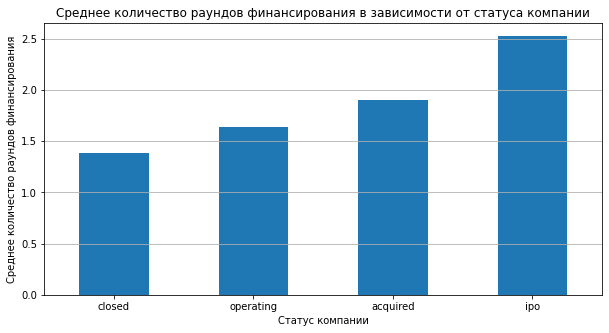

In [231]:
# Создаём контейнер графика matplotlib и задаём его размер
#plt.figure(figsize=(12, 6))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
status_rounds[['mean']].sort_values(by = 'mean').plot(
               kind='bar', # Тип графика — столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Среднее количество раундов финансирования в зависимости от статуса компании',
               figsize=(10, 5)
)

# Настраиваем оформление графика
plt.xlabel('Статус компании')
plt.ylabel('Среднее количество раундов финансирования')
# Добавляем сетку графика
plt.grid(axis = 'y')

# Выводим график
plt.show()

Для закрытых, работающих и приобретённых компаний медианное количество раундов финансирования составляет один раунд. При этом стартапы, которые провели первичное размещение акций (IPO), в типичном случае проходят через два раунда финансирования.

В среднем наименьшее число раундов наблюдается у закрытых компаний (1.38), чуть больше — у работающих (1.64), ещё выше — у приобретённых (1.90). Максимальное среднее количество раундов фиксируется у компаний, вышедших на IPO: они в среднем проходят через 2.53 раунда финансирования.

Таким образом, стартапы, достигшие стадии IPO, привлекают больше раундов финансирования, что логично: для выхода на биржу компании требуется больше инвестиций и времени на развитие. В то же время закрытые компании имеют меньше всего раундов, что может говорить о том, что они либо быстро прекратили деятельность, не сумев привлечь достаточное финансирование, либо не смогли заинтересовать инвесторов. Приобретённые компании и стартапы, которые продолжают работать, занимают промежуточные позиции: они обычно проходят через 1–2 раунда, что отражает разные сценарии их развития.


## Шаг 4. Итоговый вывод и рекомендации

В рамках исследования были изучены данные о финансировании 217 774 стартапов. Данные включали информацию о компаниях, раундах финансирования, сделках по их приобретению, а также данные о сотрудниках, включая образование. Целью исследования было выявить показатели и признаки, которые указывают на повышенную вероятность успешной сделки по покупке компании.

#### Основные выводы исследования
- С 1999 по 2005 год показатели типичного размера финансирования росли и достигли пика в 2005-м (5,5 млн), после чего резко снизились. При этом количество раундов финансирования росло на протяжении всего исследуемого периода. 
- Типичный размер общего финансирования для стартапа составляет 0,5–11 млн долларов.
- Наиболее крупные компании (26 и более сотрудников) имеют в среднем больше информации о сотрудниках.
- Категории стартапов с типично высокими ценами покупки: чистые технологии, безопасность, биотехнологии, электронная коммерция, полупроводники.
- Категории с наибольшим разбросом цен за стартап: безопасность, биотехнологии, аппаратное обеспечение, сетевой хостинг, электронная коммерция.
- Приобретенные компании имеют обычно 1-2 раунда финансирования. Больше всего раундов финансирования привлекают стартапы, достигшие стадии IPO — в среднем 2-3 раунда. Закрытые компании имеют меньше всего раундов финансирования.

#### Рекомендации
- При выборе направлений для инвестиций стоит обратить внимание на стартапы в сферах `чистых технологий, безопасности, биотехнологий, электронной коммерции, полупроводников`. В этих категориях зафиксированы высокие медианные цены сделок, что свидетельствует о потенциале для значительных доходов при успешном развитии компаний. 
- Особое внимание стоит уделить категориям с высоким разбросом цен, таким как `безопасность`, `биотехнологии`, `электронная коммерция`. Эти сферы сочетают в себе высокие типичные цены сделок и значительный диапазон цен, что может указывать на возможность заключения крайне выгодных сделок. При этом риск может быть умеренным, поскольку даже медианные значения находятся на высоком уровне.
- При оценке перспективности стартапов можно использовать такие признаки, как `число раундов финансирования, общий размер финансирования, отрасль стартапа и полнота информации о сотрудниках`.
- Приоритет стоит отдавать стартапам, которые привлекли хотя бы 1 раунд финансирования. Отсутствие раундов (0) может говорить о том, что стартап не сумел заинтересовать инвесторов или что данные неполные. При этом большинство успешно приобретённых или вышедших на IPO стартапов имеют в среднем от 1 до 3 раундов, что можно считать рабочим ориентиром при оценке перспективности проекта.